# Oversampling

In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR
from scipy.stats import entropy


### Read the CSV

In [4]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("../model_dev/densenet_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("../model_dev/densenet_data/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("../model_dev/densenet_data/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(train_initial.columns)
train_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient02424/study8/view1_frontal.jpg,train/patient02424/study8/view1_frontal.dcm,52.0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,"[0.0036964279133826494, 0.026995880529284477, ..."
1,train/patient08517/study10/view1_frontal.jpg,train/patient08517/study10/view1_frontal.dcm,53.0,0,1,2,0,0,1,1,...,1,0,0,0,0,0,0,0,1,"[0.0035102381370961666, 0.11090341955423355, 0..."
2,train/patient03164/study14/view1_frontal.jpg,train/patient03164/study14/view1_frontal.dcm,80.0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,"[0.005892541725188494, 0.1605752557516098, 0.1..."
3,train/patient28576/study3/view1_frontal.jpg,train/patient28576/study3/view1_frontal.dcm,63.0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0.0012315319618210196, 0.013657770119607449, ..."
4,train/patient35066/study5/view1_frontal.jpg,train/patient35066/study5/view1_frontal.dcm,59.0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,"[0.0032588730100542307, 0.02126752771437168, 0..."


### Convert embeddings from str to list (a bit long for large data sets)

In [5]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [6]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [7]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

### Remove columns

In [8]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [9]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = valid.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = valid.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 3


### Convert age to binary to study bias

In [10]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

### Create artificial training distribution

In [11]:
print("Initial sex Distribution:")
print(train['sex'].value_counts())

print("\nInitial Race Distribution:")
print(train['race'].value_counts())

print("\nInitial Age Distribution:")
print(train['age'].value_counts())

print("\nInitial Health Distribution:")
print(train['insurance_type'].value_counts())

Initial sex Distribution:
sex
0    38998
1    28198
Name: count, dtype: int64

Initial Race Distribution:
race
0    52553
1     9844
2     4799
Name: count, dtype: int64

Initial Age Distribution:
age
0    42267
1    24929
Name: count, dtype: int64

Initial Health Distribution:
insurance_type
1    43076
2    18340
0     5780
Name: count, dtype: int64


In [12]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
other_cols = ['age', 'sex', 'race', 'insurance_type','embeddings']

train = train[diseases + other_cols]

### Remove embeddings that contain too much information concerning the subgroups

In [13]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist())
test_embeddings = pd.DataFrame(test['embeddings'].tolist())
valid_embeddings = pd.DataFrame(valid['embeddings'].tolist())

In [14]:
emb_to_remove = [634, 611, 304, 885, 867, 508, 892, 973, 889, 441, 160, 416, 632, 13, 630, 371, 105, 108]

train_embeddings.drop(columns=emb_to_remove, inplace=True)
test_embeddings.drop(columns=emb_to_remove, inplace=True)
valid_embeddings.drop(columns=emb_to_remove, inplace=True)

len_embeddings = 1024 - len(emb_to_remove)


### Train evaluate test

In [41]:
# Diseases to predict
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]
y_valid = valid[diseases]
y_no_finding = test["No Finding"]
y_sex = test['sex']
y_race = test['race']
y_insurance = test['insurance_type']
y_age = test['age']

In [42]:
learning_rate = 0.0005
weight_decay = 0
dropout = 0.5
batch_size = 256

# learning_rate = 0.01
# weight_decay = 0
# dropout = 0.5
# batch_size = 256

In [43]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - Convert dataframes to tensors and create dataloaders
X_train = torch.tensor(train_embeddings.values).float().to(device)
y_train = torch.tensor(y_train.values).float().to(device)
X_test = torch.tensor(test_embeddings.values).float().to(device)
y_test = torch.tensor(y_test.values).float().to(device)
X_valid = torch.tensor(valid_embeddings.values).float().to(device)
y_valid = torch.tensor(y_valid.values).float().to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
valid_data = TensorDataset(X_valid, y_valid)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


In [44]:

# Assuming y_train is a tensor of shape (num_samples, num_classes)
# where each element is 0 or 1 indicating the absence or presence of a class

def calculate_sample_weights(y_train):
    # Calculate the frequency of each class
    class_counts = y_train.sum(axis=0)
    print(class_counts)
    # Compute the weight for each class (inverse frequency, normalized)
    class_weights = 1. / (class_counts + 1e-5)  # Add a small value to avoid division by zero
    class_weights /= class_weights.sum()  # Normalize so that sum of weights is 1
    print(class_weights)
    
    # Compute the sample weights
    sample_weights = torch.mm(y_train, class_weights.unsqueeze(1)).squeeze()
    
    return sample_weights

sample_weights = calculate_sample_weights(y_train)

# Convert sample weights to a Sampler compatible format
weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create DataLoader using the WeightedRandomSampler
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=weighted_sampler)


tensor([ 8210., 33270., 15994., 26712.], device='cuda:0')
tensor([0.4837, 0.1194, 0.2483, 0.1487], device='cuda:0')


In [45]:

# Define a more complex neural network
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(MultiLabelNN, self).__init__()
        # Increase the complexity by adding more layers and a wider network
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(512, 256)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(256, 128)  # Third hidden layer
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(128, output_size)  # Output layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [46]:

# # Define the simplified neural network
# class MultiLabelNN(nn.Module):
#     def __init__(self, input_size, output_size, dropout):
#         super(MultiLabelNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
#         self.fc3 = nn.Linear(128, output_size)  # Output layer size = number of diseases
#         self.relu = nn.ReLU()  # ReLU activation function
#         self.dropout = nn.Dropout(dropout)  # Dropout for regularization

#     def forward(self, x):
#         x = self.fc1(x)  # First linear transformation
#         x = self.relu(x)  # Activation function
#         x = self.dropout(x)  # Apply dropout
#         x = self.fc3(x)  # Final linear transformation to output size
#         return x


In [47]:
# Calculate weights inversely proportional to class frequencies
class_counts = y_train.sum(axis=0)
class_weights = 1.0 / (class_counts + 1e-5)
class_weights = class_weights / class_weights.mean()  # Normalizing


# Example to increase the weight of positive examples in loss calculation
pos_weights = torch.ones([len(diseases)]).to(device)  # one weight per class
pos_weights *= 5  # Increasing the weights for positive examples

# Use these weights in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


In [48]:
model = MultiLabelNN(len_embeddings, len(diseases), dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [49]:
# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=1) 

In [50]:


def train_model(train_loader, validation_loader, model, criterion, optimizer, scheduler, num_epochs):
    model.train()
    training_stats = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_val_loss = 0, 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        training_stats['train_loss'].append(total_loss / len(train_loader))

        # Validation loss calculation
        model.eval()
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        training_stats['val_loss'].append(total_val_loss / len(validation_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_stats["train_loss"][-1]:.4f}, Validation Loss: {training_stats["val_loss"][-1]:.4f}')

        # Update the learning rate
        scheduler.step()


    return training_stats


Epoch 1/5, Training Loss: 0.5872, Validation Loss: 0.5324
Epoch 2/5, Training Loss: 0.5677, Validation Loss: 0.5313
Epoch 3/5, Training Loss: 0.5606, Validation Loss: 0.5259
Epoch 4/5, Training Loss: 0.5576, Validation Loss: 0.5138
Epoch 5/5, Training Loss: 0.5533, Validation Loss: 0.5042


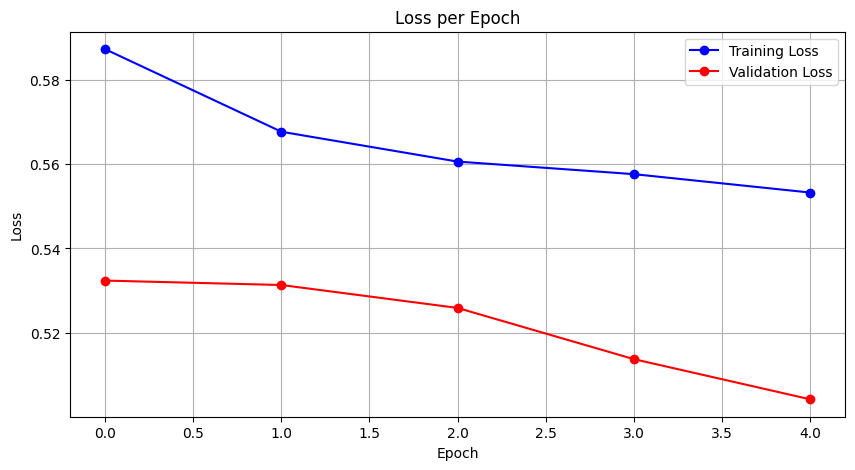

In [51]:
# Run training
nb_epoch = 5
stats = train_model(train_loader, valid_loader, model, criterion, optimizer, scheduler, nb_epoch)

# Plotting the training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(stats['train_loss'], marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(stats['val_loss'], marker='o', linestyle='-', color='red', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
# Function to evaluate the model
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predicted = torch.sigmoid(output).cpu().numpy()
            all_preds.append(predicted)
            all_targets.append(target.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return all_preds, all_targets

In [53]:
# Evaluate on test data
predictions, targets = evaluate_model(test_loader)

# Create the no finding column
updated_predictions = []

for row in predictions:
    # Check if all elements in the row are less than or equal to 0.5
    if np.all(row <= 0.5):
        new_row = np.append(row, 1)
    else:
        new_row = np.append(row, 0)
    updated_predictions.append(new_row)

predictions = np.array(updated_predictions)

updated_targets = []
for target, no_finding_target in zip(targets, y_no_finding):
    new_target = np.append(target, no_finding_target)
    updated_targets.append(new_target)

targets = np.array(updated_targets)



In [54]:
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Pleural Effusion']



In [55]:
def compute_metrics(predictions, targets):
    # Calculate metrics for each disease
    metrics = {}
    for idx, disease in enumerate(diseases):
        disease_pred = predictions[:, idx]
        disease_true = targets[:, idx]
        auc_roc = roc_auc_score(disease_true, disease_pred)
        f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
        accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
        tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
        tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
        auprc = auc(recall, precision)

        metrics[disease] = {
            'Accuracy': accuracy,
            'AUC': auc_roc,
            'AUPRC': auprc,
            'F1 Score': f1,
            'TP Rate': tp_rate,
            'FN Rate': fn_rate,
            'TN Rate': tn_rate,
            'FP Rate': fp_rate
        }
    return metrics

metrics = compute_metrics(predictions, targets)
print(metrics)

{'Cardiomegaly': {'Accuracy': 0.7709578981318381, 'AUC': 0.8039710475269607, 'AUPRC': 0.4022835123972135, 'F1 Score': 0.423288355822089, 'TP Rate': 0.6830645161290323, 'FN Rate': 0.31693548387096776, 'TN Rate': 0.7832913684329647, 'FP Rate': 0.2167086315670354}, 'Lung Opacity': {'Accuracy': 0.6005408489840475, 'AUC': 0.6362354114623014, 'AUPRC': 0.5976336081503129, 'F1 Score': 0.6471323062087707, 'TP Rate': 0.7440032251562185, 'FN Rate': 0.25599677484378147, 'TN Rate': 0.461418169378879, 'FP Rate': 0.5385818306211211}, 'Edema': {'Accuracy': 0.7135485151462525, 'AUC': 0.7769631175105767, 'AUPRC': 0.497870460253134, 'F1 Score': 0.5331176708451274, 'TP Rate': 0.6806401652039236, 'FN Rate': 0.3193598347960764, 'TN Rate': 0.7239566324864477, 'FP Rate': 0.27604336751355235}, 'Pleural Effusion': {'Accuracy': 0.7421539682933486, 'AUC': 0.8128928999360122, 'AUPRC': 0.7106145731475768, 'F1 Score': 0.6870238202788569, 'TP Rate': 0.7179180565170873, 'FN Rate': 0.2820819434829127, 'TN Rate': 0.7579

### Compute metrics for different categories

In [56]:
def create_distributions(y_true, y_pred):
            P = np.array([1 - y_true, y_true]).T  # Probabiility distribution of True Labels
            Q = np.array([1 - y_pred, y_pred]).T  # Probabiility distribution of predicted diseases
            return P, Q

In [57]:
predictions

array([[0.15911633, 0.60499167, 0.58512956, 0.66786885, 0.        ],
       [0.12966955, 0.58665991, 0.51142061, 0.55180496, 0.        ],
       [0.30033788, 0.45667359, 0.34438986, 0.14356248, 1.        ],
       ...,
       [0.09433403, 0.61289132, 0.43155342, 0.44902867, 0.        ],
       [0.23445731, 0.48542747, 0.36112913, 0.1329996 , 1.        ],
       [0.12882102, 0.62330776, 0.11130048, 0.39877045, 0.        ]])

In [58]:

# Calculate metrics for each disease and for each class

metrics_female = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 1, idx]
    disease_true = targets[y_sex == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)

    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_female[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_male = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_sex == 0, idx]
    disease_true = targets[y_sex == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_male[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    

metrics_white = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 0, idx]
    disease_true = targets[y_race == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_white[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_black = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 2, idx]
    disease_true = targets[y_race == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_black[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_asian = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_race == 1, idx]
    disease_true = targets[y_race == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_asian[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    

metrics_medicaid = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 0, idx]
    disease_true = targets[y_insurance == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_medicaid[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_medicare = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 1, idx]
    disease_true = targets[y_insurance == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_medicare[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_private = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_insurance == 2, idx]
    disease_true = targets[y_insurance == 2, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_private[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    

metrics_young = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 0, idx]
    disease_true = targets[y_age == 0, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)
    
    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_young[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }
    
metrics_old = {}
for idx, disease in enumerate(diseases):
    # disease_pred = predictions[:, idx]
    disease_pred = predictions[y_age == 1, idx]
    disease_true = targets[y_age == 1, idx]
    auc_roc = roc_auc_score(disease_true, disease_pred)
    f1 = f1_score(disease_true, (disease_pred > 0.5).astype(int))
    accuracy = accuracy_score(disease_true, (disease_pred > 0.5).astype(int))
    tn, fp, fn, tp = confusion_matrix(disease_true, (disease_pred > 0.5).astype(int)).ravel()
    tp_rate = tp / (tp + fn)
    tn_rate = tn / (tn + fp)
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (tn + fp)

    precision, recall, _ = precision_recall_curve(disease_true, disease_pred)
    auprc = auc(recall, precision)


    # KL-Divergence
    P, Q = create_distributions(disease_true, disease_pred)
    kl_div = np.mean([entropy(P_row, Q_row) for P_row, Q_row in zip(P, Q)])

    metrics_old[disease] = {
        'Accuracy': accuracy,
        'AUC': auc_roc,
        'AUPRC': auprc,
        'F1 Score': f1,
        'TP Rate': tp_rate,
        'FN Rate': fn_rate,
        'TN Rate': tn_rate,
        'FP Rate': fp_rate,
        'KL Div': kl_div
        }

In [59]:
metrics_female

{'Cardiomegaly': {'Accuracy': 0.7729368645069756,
  'AUC': 0.8004680650030256,
  'AUPRC': 0.37405446060162156,
  'F1 Score': 0.4036640273249495,
  'TP Rate': 0.6694129763130793,
  'FN Rate': 0.3305870236869207,
  'TN Rate': 0.7863630292507012,
  'FP Rate': 0.21363697074929877,
  'KL Div': 0.49009421017781435},
 'Lung Opacity': {'Accuracy': 0.5986048711279263,
  'AUC': 0.6304111963142156,
  'AUPRC': 0.5925613947631381,
  'F1 Score': 0.6494941152178402,
  'TP Rate': 0.7510744985673352,
  'FN Rate': 0.24892550143266476,
  'TN Rate': 0.4490632318501171,
  'FP Rate': 0.5509367681498829,
  'KL Div': 0.6683303191635694},
 'Edema': {'Accuracy': 0.7105107590446914,
  'AUC': 0.7735350702323934,
  'AUPRC': 0.5021770679965263,
  'F1 Score': 0.5333968556455455,
  'TP Rate': 0.6773959341723137,
  'FN Rate': 0.32260406582768636,
  'TN Rate': 0.7212140175219024,
  'FP Rate': 0.2787859824780976,
  'KL Div': 0.5361473195942285},
 'Pleural Effusion': {'Accuracy': 0.7456845589973989,
  'AUC': 0.8169272735

In [60]:
# Initialize an empty list to store the data
data_sex = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_male = metrics_male[disease]['AUPRC'] *100
    auc_female = metrics_female[disease]['AUPRC'] *100
    tp_rate_male = metrics_male[disease]['TP Rate'] *100
    tp_rate_female = metrics_female[disease]['TP Rate'] *100
    fp_rate_male = metrics_male[disease]['FP Rate'] *100
    fp_rate_female = metrics_female[disease]['FP Rate'] *100

    kl1 = metrics_male[disease]['KL Div'] *100
    kl2 = metrics_female[disease]['KL Div'] *100

    
    delta_KL_sex = abs(kl1 - kl2)


    # Calculate delta AUC and equality of odds
    delta_auc_sex = abs(auc_male - auc_female) 
    eq_odds_sex = 0.5 * (abs(tp_rate_male - tp_rate_female) + abs(fp_rate_male - fp_rate_female))
    
    # Append to the data list
    data_sex.append([disease, auprc_overall, auc_overall, auc_male, auc_female, delta_auc_sex, eq_odds_sex, delta_KL_sex])

# Create a DataFrame
df_sex = pd.DataFrame(data_sex, columns=['Disease', 'AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds', 'KL div'])


# Styling the DataFrame
styled_df = df_sex.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_Male': "{:.3f}", 
    'AUC_Female': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}",
    'KL div': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_Male', 'AUC_Female', 'Delta AUC', 'EqOdds', 'KL div'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_Male,AUC_Female,Delta AUC,EqOdds,KL div
0,Cardiomegaly,40.228,80.397,42.079,37.405,4.674,1.388,0.992
1,Lung Opacity,59.763,63.624,60.136,59.256,0.879,1.672,0.166
2,Edema,49.787,77.696,49.538,50.218,0.680,0.518,0.946
3,Pleural Effusion,71.061,81.289,70.655,71.662,1.007,2.536,0.442


In [61]:
# Initialize an empty list to store the data
data_race = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_white[disease]['AUPRC'] *100,
        metrics_black[disease]['AUPRC'] *100,
        metrics_asian[disease]['AUPRC'] *100
    ]
    tp_rates = [
        metrics_white[disease]['TP Rate'] *100,
        metrics_black[disease]['TP Rate'] *100,
        metrics_asian[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_white[disease]['FP Rate'] *100,
        metrics_black[disease]['FP Rate'] *100,
        metrics_asian[disease]['FP Rate'] *100
    ]

    kl_rates = [
        metrics_white[disease]['KL Div'] *100,
        metrics_black[disease]['KL Div'] *100,
        metrics_asian[disease]['KL Div'] *100
    ]

    delta_kl_race = max(abs(kl_rates[i] - kl_rates[j]) for i in range(len(kl_rates)) for j in range(i + 1, len(kl_rates)))

    # Calculate the maximum delta AUC
    delta_auc_race = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_race = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_race.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_race, eq_odds_race, delta_kl_race])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds', 'KL div']
df_race = pd.DataFrame(data_race, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_race.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_White': "{:.3f}", 
    'AUC_Black': "{:.3f}",
    'AUC_Asian': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}",
    'KL div': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC', 'AUC_White', 'AUC_Black', 'AUC_Asian', 'Max Delta AUC', 'Max EqOdds', 'KL div'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_White,AUC_Black,AUC_Asian,Max Delta AUC,Max EqOdds,KL div
0,Cardiomegaly,40.228,80.397,37.411,55.240,42.365,17.829,11.303,7.100
1,Lung Opacity,59.763,63.624,59.885,59.676,59.239,0.646,12.688,1.173
2,Edema,49.787,77.696,50.162,51.453,46.784,4.669,2.784,4.081
3,Pleural Effusion,71.061,81.289,71.103,64.358,73.191,8.833,6.088,2.100


In [62]:
# Initialize an empty list to store the data
data_age = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    # Extract AUC and rates from dictionaries
    
    auprc_overall = values['AUPRC'] *100

    auc_overall = values['AUC'] *100
    auc_old = metrics_old[disease]['AUPRC'] *100
    auc_young = metrics_young[disease]['AUPRC'] *100
    tp_rate_old = metrics_old[disease]['TP Rate'] *100
    tp_rate_young = metrics_young[disease]['TP Rate'] *100
    fp_rate_old = metrics_old[disease]['FP Rate'] *100
    fp_rate_young = metrics_young[disease]['FP Rate'] *100


    kl1 = metrics_old[disease]['KL Div'] *100
    kl2 = metrics_young[disease]['KL Div'] *100

    
    delta_KL_age = abs(kl1 - kl2)

    
    # Calculate delta AUC and equality of odds
    delta_auc_age = abs(auc_old - auc_young)
    eq_odds_age = 0.5 * (abs(tp_rate_old - tp_rate_young) + abs(fp_rate_old - fp_rate_young))
    
    # Append to the data list
    data_age.append([disease, auprc_overall, auc_overall, auc_old, auc_young, delta_auc_age, eq_odds_age, delta_KL_age])

# Create a DataFrame
df_age = pd.DataFrame(data_age, columns=['Disease', 'AUPRC', 'AUC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds', 'KL div'])


# Styling the DataFrame
styled_df = df_age.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}",
    'AUC_old': "{:.3f}", 
    'AUC_young': "{:.3f}",
    'Delta AUC': "{:.3f}",
    'EqOdds': "{:.3f}",
    'KL div': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUC', 'AUPRC', 'AUC_old', 'AUC_young', 'Delta AUC', 'EqOdds', 'KL div'])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,AUC_old,AUC_young,Delta AUC,EqOdds,KL div
0,Cardiomegaly,40.228,80.397,39.793,40.736,0.942,4.546,8.971
1,Lung Opacity,59.763,63.624,61.631,58.658,2.973,1.293,0.275
2,Edema,49.787,77.696,53.172,47.408,5.764,3.189,5.642
3,Pleural Effusion,71.061,81.289,72.998,69.734,3.264,4.506,2.414


In [63]:
# Initialize an empty list to store the data
data_health = []

# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] *100
    auc_overall = values['AUC'] *100
    auc_groups = [
        metrics_medicaid[disease]['AUPRC'] *100,
        metrics_medicare[disease]['AUPRC'] *100,
        metrics_private[disease]['AUPRC'] *100
    ]
    tp_rates = [
        metrics_medicaid[disease]['TP Rate'] *100,
        metrics_medicare[disease]['TP Rate'] *100,
        metrics_private[disease]['TP Rate'] *100
    ]
    fp_rates = [
        metrics_medicaid[disease]['FP Rate'] *100,
        metrics_medicare[disease]['FP Rate'] *100,
        metrics_private[disease]['FP Rate'] *100
    ]

    kl_rates = [
        metrics_medicaid[disease]['KL Div'] *100,
        metrics_medicare[disease]['KL Div'] *100,
        metrics_private[disease]['KL Div'] *100
    ]

    delta_kl_health = max(abs(kl_rates[i] - kl_rates[j]) for i in range(len(kl_rates)) for j in range(i + 1, len(kl_rates)))

    # Calculate the maximum delta AUC
    delta_auc_health = max(abs(auc_groups[i] - auc_groups[j]) for i in range(len(auc_groups)) for j in range(i + 1, len(auc_groups)))

    # Calculate the maximum equality of odds
    eq_odds_health = max(
        0.5 * (abs(tp_rates[i] - tp_rates[j]) + abs(fp_rates[i] - fp_rates[j]))
        for i in range(len(tp_rates)) for j in range(i + 1, len(tp_rates))
    )

    # Append to the data list
    data_health.append([disease, auprc_overall, auc_overall] + auc_groups + [delta_auc_health, eq_odds_health, delta_kl_health])

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds', 'KL div']
df_health = pd.DataFrame(data_health, columns=columns)

# Display the DataFrame with styling
# Styling the DataFrame
styled_df = df_health.style.format({
    'AUC': "{:.3f}", 
    'AUPRC': "{:.3f}", 
    'AUC_Medicaid': "{:.3f}", 
    'AUC_Medicare': "{:.3f}",
    'AUC_Private': "{:.3f}",
    'Max Delta AUC': "{:.3f}",
    'Max EqOdds': "{:.3f}",
    'KL div': "{:.3f}"
}).background_gradient(cmap='viridis', subset=['AUPRC', 'AUC',  'AUC_Medicaid', 'AUC_Medicare', 'AUC_Private', 'Max Delta AUC', 'Max EqOdds', 'KL div'])

# Display the styled DataFrame
styled_df

,Disease,AUPRC,AUC,AUC_Medicaid,AUC_Medicare,AUC_Private,Max Delta AUC,Max EqOdds,KL div
0,Cardiomegaly,40.228,80.397,39.092,41.537,36.258,5.279,6.625,7.750
1,Lung Opacity,59.763,63.624,64.171,60.719,56.319,7.852,2.379,1.059
2,Edema,49.787,77.696,44.985,51.795,45.816,6.811,3.843,6.266
3,Pleural Effusion,71.061,81.289,68.952,71.998,69.086,3.046,5.116,3.651


In [64]:
# Initialize an empty list to store the data
data = []
i = 0

# Assuming 'metrics', 'df_sex', 'df_race', 'df_age', and 'df_health' are predefined and correctly structured
# Iterate over the diseases in the metrics dictionary
for disease, values in metrics.items():
    auprc_overall = values['AUPRC'] * 100
    auc_overall = values['AUC'] * 100

    # Append to the data list
    data.append([disease, auprc_overall, auc_overall] +
                [df_sex['Delta AUC'][i], df_sex['EqOdds'][i], df_sex['KL div'][i]] +
                [df_race['Max Delta AUC'][i], df_race['Max EqOdds'][i], df_race['KL div'][i]] +
                [df_age['Delta AUC'][i], df_age['EqOdds'][i], df_age['KL div'][i]] +
                [df_health['Max Delta AUC'][i], df_health['Max EqOdds'][i], df_health['KL div'][i]])
    i += 1

# Create a DataFrame
columns = ['Disease', 'AUPRC', 'AUC', 'Delta AUPRC sex', 'EqOdds sex', 'KL div sex',
           'Delta AUPRC race', 'EqOdds race', 'KL div race', 'Delta AUPRC age', 'EqOdds age', 'KL div age',
           'Delta AUPRC health', 'EqOdds health', 'KL div health']
df = pd.DataFrame(data, columns=columns)

# Styling the DataFrame
styled_df = df.style.format({
    'AUPRC': "{:.1f}",
    'AUC': "{:.1f}",
    'Delta AUPRC sex': "{:.1f}",
    'EqOdds sex': "{:.1f}",
    'KL div sex': "{:.1f}",
    'Delta AUPRC race': "{:.1f}",
    'EqOdds race': "{:.1f}",
    'KL div race': "{:.1f}",
    'Delta AUPRC age': "{:.1f}",
    'EqOdds age': "{:.1f}",
    'KL div age': "{:.1f}",
    'Delta AUPRC health': "{:.1f}",
    'EqOdds health': "{:.1f}",
    'KL div health': "{:.1f}"
}).background_gradient(cmap='OrRd', subset=[
    'AUPRC', 'AUC', 'Delta AUPRC sex', 'EqOdds sex', 'KL div sex', 'Delta AUPRC race', 'EqOdds race', 'KL div race',
    'Delta AUPRC age', 'EqOdds age', 'KL div age', 'Delta AUPRC health', 'EqOdds health', 'KL div health'
])

# Display the styled DataFrame
styled_df


,Disease,AUPRC,AUC,Delta AUPRC sex,EqOdds sex,KL div sex,Delta AUPRC race,EqOdds race,KL div race,Delta AUPRC age,EqOdds age,KL div age,Delta AUPRC health,EqOdds health,KL div health
0,Cardiomegaly,40.2,80.4,4.7,1.4,1.0,17.8,11.3,7.1,0.9,4.5,9.0,5.3,6.6,7.8
1,Lung Opacity,59.8,63.6,0.9,1.7,0.2,0.6,12.7,1.2,3.0,1.3,0.3,7.9,2.4,1.1
2,Edema,49.8,77.7,0.7,0.5,0.9,4.7,2.8,4.1,5.8,3.2,5.6,6.8,3.8,6.3
3,Pleural Effusion,71.1,81.3,1.0,2.5,0.4,8.8,6.1,2.1,3.3,4.5,2.4,3.0,5.1,3.7


In [65]:
df.to_csv("remove_emb_big_nn.csv")